# Word Embedding

Word embedding is nothing fancy but methods to represent words in a numerical way. More specifically, methods to map vocabularies to vectors.

# Word2Vec

Word2vec is a neural network structure to generate word embedding by training the model on a supervised classification problem.

In Mikolov et al.,2013, two model architectures were presented, Continuous Bag-of-Words model and Skip-gram model. In this notebook we will implement the skip-gram model.

# Word2Vec(Skip-Gram)

This architecture operates with the idea that given a “context word”, we want to train a model such that the model can predict a “target word”, one of the words appeared within a predefined window size from the context word.

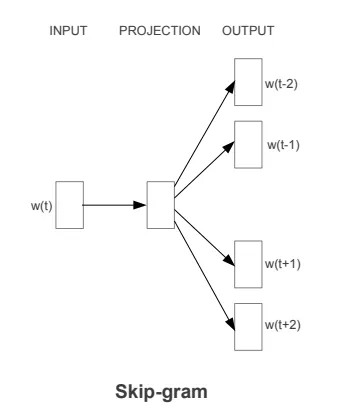

Another graph with a bit more explanation

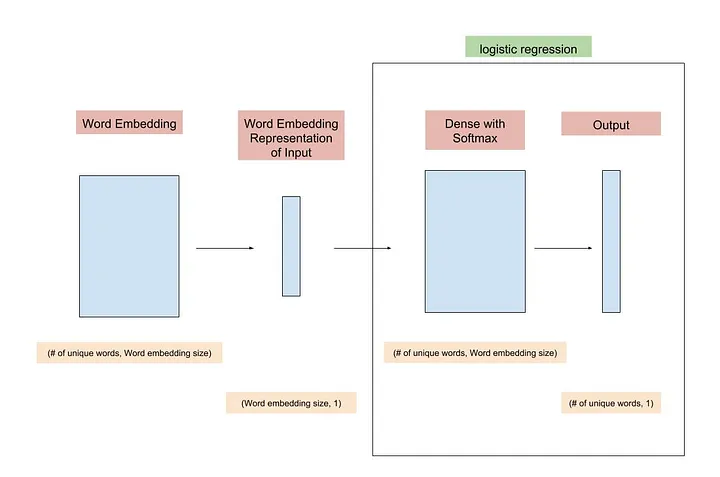

In [51]:
import re
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

In [52]:
# data for creating word embeddings

text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [53]:
# Since we can’t feed raw string texts into our model,so we are definig function for tokenizing the text, i.e.
# splitting the text up into smaller units like words, getting rid of punctuations
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [54]:
# creating tokens of our input text
tokens = tokenize(text)

In [55]:
# here we are defining a function for mapping ids against words and words against id's
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [56]:
# calling the function to map tokens
word_to_id, id_to_word = mapping(tokens)
word_to_id

{'programmed': 0,
 'of': 1,
 'a': 2,
 'is': 3,
 'sample': 4,
 'develop': 5,
 'automatically': 6,
 'computer': 7,
 'decisions': 8,
 'being': 9,
 'build': 10,
 'wide': 11,
 'tasks': 12,
 'without': 13,
 'the': 14,
 'on': 15,
 'to': 16,
 'as': 17,
 'learning': 18,
 'algorithms': 19,
 'through': 20,
 'are': 21,
 'in': 22,
 'applications': 23,
 'experience': 24,
 'intelligence': 25,
 'artificial': 26,
 'needed': 27,
 'used': 28,
 'predictions': 29,
 'perform': 30,
 'it': 31,
 'mathematical': 32,
 'such': 33,
 'variety': 34,
 'model': 35,
 'training': 36,
 'that': 37,
 'do': 38,
 'vision': 39,
 'based': 40,
 'subset': 41,
 'improve': 42,
 'or': 43,
 'difficult': 44,
 'infeasible': 45,
 'data': 46,
 'filtering': 47,
 'email': 48,
 'and': 49,
 'study': 50,
 'so': 51,
 'order': 52,
 'where': 53,
 'make': 54,
 'conventional': 55,
 'seen': 56,
 'machine': 57,
 'explicitly': 58,
 'known': 59}

# Generating Training Data

The main idea is that we will loop through each word (or token) in the sentence. In each loop, we look at words to the left and right of the input word, as shown below.

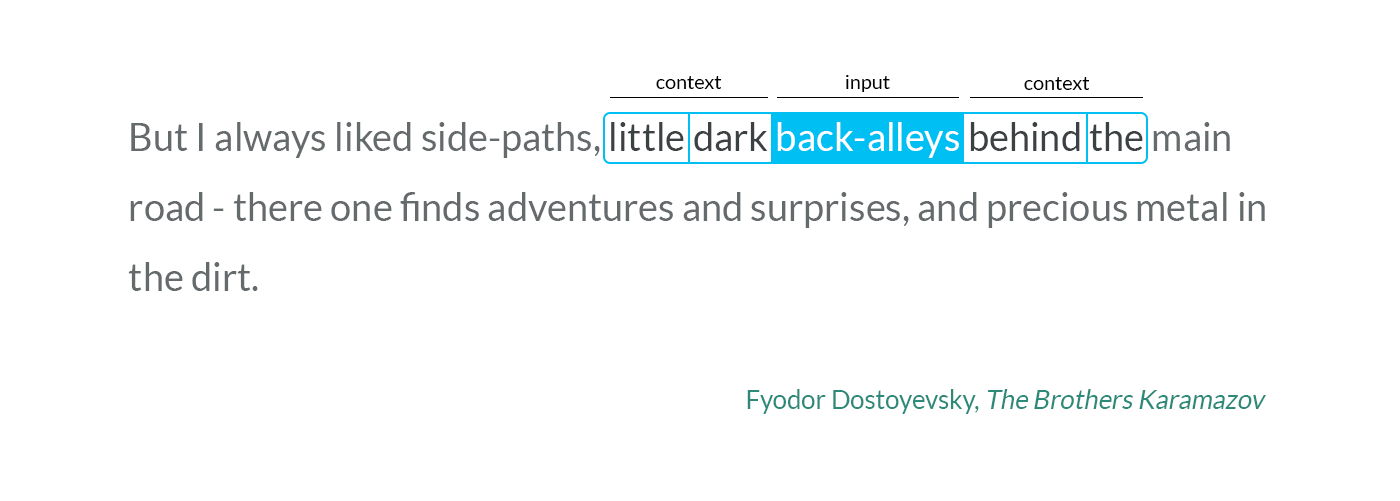

Following input and prediction pairs would be generated 

["back-alleys", "little"]
["back-alleys", "dark"]
["back-alleys", "behind"]
["back-alleys", "the"]

Here window size is 2

In [57]:
# an auxiliary function to combine two range() objects.

def concat(*iterables):
    for iterable in iterables:
        yield from iterable
    
# code to one-hot vectorize tokens

def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

# code for generating training data

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        #print(range(max(0, i - window), i))
        #print( range(i, min(n_tokens, i + window + 1)))
        for j in idx:
            #print(j)
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [58]:
X, y = generate_training_data(tokens, word_to_id, 2)

In [59]:
X.shape

# 330 is the number of training examples we have, larger the window size larger the training examples
# 60 is the number of unique tokens we have in the original text

(330, 60)

Question here arises is that how training a neural network that predicts some nearby context word given an input token can be used to embed words into vectors.

To understand this concept, we will consider we have 5 words in our corpus and we want to embed them as 3-dimensional vectors  

The rows of the intermediate weight matrix is the embedding of our concern

More specifically, here is the first weight layer of the model:

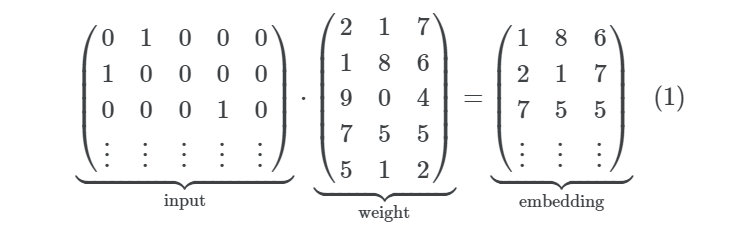

In this particular example, the weight matrix was a transformation of R5→R3.




Continuing onwards, here is the second layer that receives as input the embeddings, then uses them to generate a set of outputs.

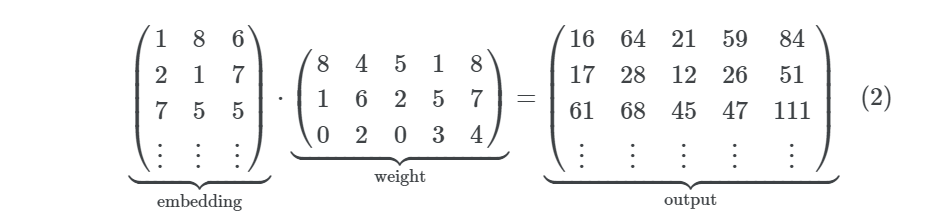

We are almost done. All we now need in the last layer is a softmax layer. When the output is passed into this layer, it is converted into probability vectors whose elements sum up to one. This final output can be considered as context predictions, i.e. which words are likely to be in the window vicinity of the input word.

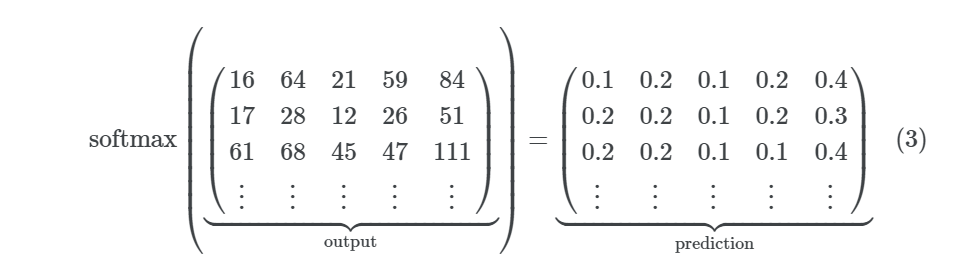

Error Function

                            H(p,q)=−∑(x∈χ)p(x)logq(x)---> cross-entropy function

Alternate for cross entropy function would be:

                                        H(p,q)= −p⋅log(q)
                                        
because that is essentially what the summation is doing. P a one-hot encoded vector in this case, all the elements in p whose entry is zero will have no effect on the final outcome. Indeed, we simply end up taking the negative log of the prediction.

In [60]:
# dictionary representation of model, where values are weight matrices and keys are name for those matrices

def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [61]:
# specifying our model to create 10-dimensional embedding

model = init_network(len(word_to_id), 10)

In [62]:
# receives matrix as input

def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [63]:
# forward propogation
# here @ means dot product
# holding intermediate variables in cache for back-propogation
# set return cache to false if you want final prediction vectors only

def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

In [64]:
# dimenstionality of matrix after first (embeding layer) layer

(X @ model["w1"]).shape

(330, 10)

In [65]:
# after passing through second layer as we need our the dimensions of original one hot encoding

(X @ model["w1"] @ model["w2"]).shape

(330, 60)

# Back Propogation

∂L/∂A2=Z−y

given our model

A1=XW1
A2=A1W2
Z=softmax(A2)
(where w1 and w2 are weight matrices of first and second layer)

In [66]:
#  backpropagation algorithm is simple batch gradient descent

def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

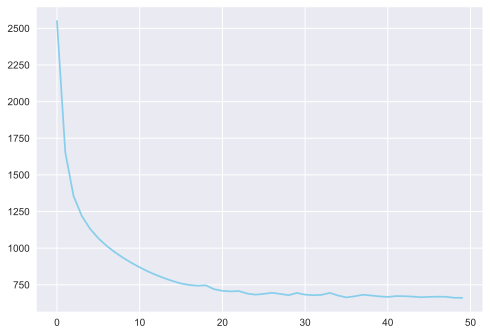

In [67]:
# storing values of cross entropy function in history and running model on 50 epochs as data set is small

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [68]:
# checking how well our model is performing by making it predict words against learning input (answers should be like machine etc)
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
are
intelligence
so
the
build
is
a
learning
algorithms
perform
conventional
develop
subset
used
infeasible
artificial
do
programmed
it
order
training
study
in
predictions
as
needed
computer
to
experience
wide
of
that
tasks
explicitly
improve
being
known
variety
based
seen
applications
difficult
on
automatically
through
without
make
or
such
mathematical
where
sample
data
model
email
decisions
and
filtering
vision


In [69]:
# Embedding

model["w1"]

array([[-1.44392971,  0.456319  , -1.23605288,  0.967511  , -1.12675342,
         1.72796379,  0.72512354,  0.63484163, -0.74284956, -0.36186741],
       [ 0.06477325,  1.78754958, -0.3515231 , -1.79033109,  0.32626193,
        -2.02821963, -0.56345889, -0.75736317, -0.02086772, -0.90496307],
       [ 0.36854376,  0.66439729,  1.39112226,  1.15955824,  0.52109362,
        -0.80566037, -1.16683116, -1.14601397, -1.72433387, -0.53861484],
       [ 0.7546597 ,  0.56406434,  0.30914846, -1.38374781, -0.22834886,
         1.6580835 , -1.81957169, -1.42170315,  0.06680187,  0.03120341],
       [-0.05093802, -0.67247132,  0.04570272,  0.09314671, -1.48261934,
        -2.1914699 , -0.20177457,  1.71039962,  0.92987185, -0.9517413 ],
       [ 0.32582129,  0.66659968,  0.64669354,  1.0359264 ,  1.49399519,
         1.0700601 ,  1.20172025, -0.54731121, -1.69100802, -0.26069649],
       [-0.19638694, -0.21955491,  1.271214  , -0.14094985, -0.15166083,
         2.46029938,  0.36766474,  1.61055264

In [70]:
# embedding vector against given input word

def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [71]:
# Testing

get_embedding(model, "machine")

array([ 0.15448287,  1.85229229,  0.08096905, -1.16991335,  0.0215943 ,
       -0.12230259,  0.69581501,  1.44143476,  0.24441455,  0.7480683 ])